#Importations

In [2]:
import cv2
import os
import matplotlib.pyplot as plt


#Prise des photos

In [ ]:
def capture_photo_with_zoom(output_path, camera_index=1, start_index=0):
    """
    Utilise une caméra pour capturer une photo et permet de zoomer sur le flux vidéo.
    - Pressez la barre d'espace pour capturer une photo.
    - Pressez '+' ou '-' pour zoomer avant ou arrière.
    - Pressez 'q' pour quitter.
    Args:
        output_path (str): Répertoire où enregistrer les images capturées.
        camera_index (int): Index de la caméra à utiliser (par défaut 1 pour une caméra externe).
        start_index (int): Index initial pour nommer les photos capturées.
    """
    # Création du répertoire si nécessaire
    os.makedirs(output_path, exist_ok=True)

    # Ouverture du flux vidéo
    cap = cv2.VideoCapture(camera_index, cv2.CAP_DSHOW)
    if not cap.isOpened():
        print("Erreur : Impossible d'accéder à la caméra.")
        return

    zoom_factor = 1.0  # Facteur de zoom initial
    photo_index = start_index  # Index de la première photo

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Erreur : Impossible de lire le flux vidéo.")
            break

        # Application du zoom
        height, width = frame.shape[:2]
        center_x, center_y = width // 2, height // 2
        new_width, new_height = int(width / zoom_factor), int(height / zoom_factor)

        # Définir les coordonnées pour le zoom
        x1 = max(center_x - new_width // 2, 0)
        x2 = min(center_x + new_width // 2, width)
        y1 = max(center_y - new_height // 2, 0)
        y2 = min(center_y + new_height // 2, height)

        # Recadrage pour le zoom
        zoomed_frame = frame[y1:y2, x1:x2]
        zoomed_frame = cv2.resize(zoomed_frame, (width, height), interpolation=cv2.INTER_LINEAR)

        # Affichage du flux vidéo avec zoom (toujours dans la même fenêtre)
        window_title = f"Camera View (Zoom: {zoom_factor:.1f}x)"
        cv2.imshow(window_title, zoomed_frame)

        # Gestion des touches clavier
        key = cv2.waitKey(1) & 0xFF

        if key == ord('q'):  # Quitter
            print("Programme terminé.")
            break
        elif key == ord(' '):  # Capturer une photo
            # Nommer et enregistrer la photo
            photo_name = f"photo_{photo_index:04d}.jpg"  # Format : photo_0000.jpg
            photo_path = os.path.join(output_path, photo_name)
            cv2.imwrite(photo_path, zoomed_frame)  # Enregistrer le cadre zoomé
            print(f"Photo capturée et enregistrée sous : {photo_path}")
            photo_index += 1  # Incrémenter l'index pour la prochaine photo
        elif key == ord('+'):  # Zoom avant
            zoom_factor = min(zoom_factor + 0.1, 4.0)  # Zoom maximal : 4x
        elif key == ord('-'):  # Zoom arrière
            zoom_factor = max(zoom_factor - 0.1, 1.0)  # Zoom minimal : 1x (pas de zoom)

    # Libération des ressources
    cap.release()
    cv2.destroyAllWindows()

# Appeler la fonction
output_dir = "images_pre_train"  # Répertoire pour enregistrer les photos
capture_photo_with_zoom(output_path=output_dir, camera_index=1, start_index=42)

#Vérification des dimensions

In [ ]:
def check_image_dimensions(directory, target_width, target_height):
    """
    Vérifie que toutes les images d'un répertoire ont les mêmes dimensions spécifiées.
    Affiche un message d'erreur si une image a des dimensions différentes.

    Args:
        directory (str): Le répertoire où se trouvent les images.
        target_width (int): Largeur cible des images.
        target_height (int): Hauteur cible des images.
    """
    # Vérifier si le répertoire existe
    if not os.path.exists(directory):
        print(f"Erreur : Le répertoire {directory} n'existe pas.")
        return

    # Liste de tous les fichiers dans le répertoire
    files = os.listdir(directory)

    # Vérifier les dimensions de chaque image
    for file_name in files:
        file_path = os.path.join(directory, file_name)

        # Ignorer les fichiers qui ne sont pas des images
        if not file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        # Charger l'image et vérifier ses dimensions
        img = cv2.imread(file_path)
        if img is None:
            print(f"Erreur : Impossible de charger l'image {file_name}.")
            continue

        height, width = img.shape[:2]

        # Vérifier si les dimensions correspondent à la cible
        if width != target_width or height != target_height:
            print(f"Erreur : L'image {file_name} a des dimensions {width}x{height} au lieu de {target_width}x{target_height}.")
        else:
            print(f"L'image {file_name} a les bonnes dimensions {width}x{height}.")

# Exemple d'utilisation
check_image_dimensions("images_pre_train", target_width=640, target_height=480)


#Rognage des photos

In [ ]:
def crop_images_to_target(directory, output_directory, target_width, target_height):
    """
    Rognage automatique des images dans un répertoire pour qu'elles aient toutes les mêmes dimensions spécifiées.
    Les images rognées sont enregistrées dans un répertoire de sortie.

    Args:
        directory (str): Le répertoire contenant les images à rogner.
        output_directory (str): Le répertoire où enregistrer les images rognées.
        target_width (int): Largeur cible des images.
        target_height (int): Hauteur cible des images.
    """
    # Créer le répertoire de sortie si nécessaire
    os.makedirs(output_directory, exist_ok=True)

    # Liste de tous les fichiers dans le répertoire
    files = os.listdir(directory)

    for file_name in files:
        file_path = os.path.join(directory, file_name)

        # Ignorer les fichiers qui ne sont pas des images
        if not file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        # Charger l'image
        img = cv2.imread(file_path)
        if img is None:
            print(f"Erreur : Impossible de charger l'image {file_name}.")
            continue

        height, width = img.shape[:2]

        # Si l'image est plus grande que la cible, on la rogne
        if width != target_width or height != target_height:
            # Calculer les zones à rogner pour centrer l'image
            crop_x = (width - target_width) // 2
            crop_y = (height - target_height) // 2
            cropped_img = img[crop_y:crop_y + target_height, crop_x:crop_x + target_width]

            # Enregistrer l'image rognée dans le répertoire de sortie
            output_path = os.path.join(output_directory, file_name)
            cv2.imwrite(output_path, cropped_img)
            print(f"L'image {file_name} a été rognée et enregistrée sous {output_path}.")
        else:
            # Si les dimensions sont déjà correctes, on la copie sans modification
            output_path = os.path.join(output_directory, file_name)
            cv2.imwrite(output_path, img)
            print(f"L'image {file_name} est déjà à la bonne taille, elle a été copiée sous {output_path}.")

# Exemple d'utilisation
crop_images_to_target("images_pre_train", "images_cropped", target_width=640, target_height=480)


#Redimensionnement d'image et rognage

In [7]:
from PIL import Image
import matplotlib.pyplot as plt

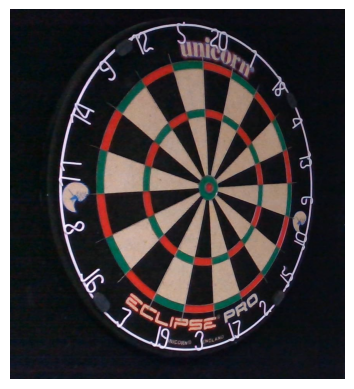

Cropped Dimensions: (870, 960)


In [11]:
def crop_and_display(image_path, left_crop, right_crop, top_crop, bottom_crop):
    with Image.open(image_path) as img:
        width, height = img.size
        cropped = img.crop((left_crop, top_crop, width - right_crop, height - bottom_crop))

        # Display the cropped image
        plt.imshow(cropped)
        plt.axis('off')  # Hide axes
        plt.show()

        return cropped  # Return the cropped image

# Example usage:
cropped = crop_and_display("img1.jpg", left_crop=100, right_crop=950, top_crop=20, bottom_crop=100)

# Display dimensions of the cropped image
print(f"Cropped Dimensions: {cropped.size}")


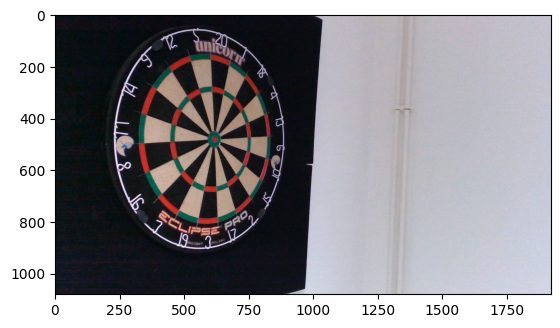

In [8]:
with Image.open("img1.jpg") as img:
  plt.imshow(img)

In [ ]:
"""def resize_with_proportions(image, new_width=None, new_height=None):
    width, height = image.size

    if new_width is not None:
        # Calculate the new height while maintaining the aspect ratio
        new_height = int((new_width / width) * height)
    elif new_height is not None:
        # Calculate the new width while maintaining the aspect ratio
        new_width = int((new_height / height) * width)
    else:
        raise ValueError("Either new_width or new_height must be specified.")

    resized_img = image.resize((new_width, new_height))
    return resized_img

# Example usage:
resized_cropped = resize_with_proportions(cropped, new_height=800)
resized_cropped.show()  # Display the resized image
print(f"Resized Dimensions: {resized_cropped.size}")
"""

In [3]:
plt.imshow(resized_cropped)

NameError: name 'resized_cropped' is not defined

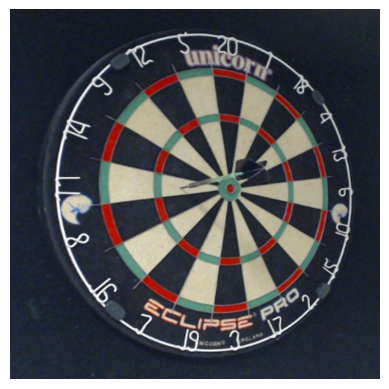

Resized Dimensions: (800, 800)


In [ ]:
def resize_to_dimensions(image, new_width, new_height):
    resized_img = image.resize((new_width, new_height))
    plt.imshow(resized_img)
    plt.axis('off')
    plt.show()
    return resized_img

# Example usage:
resized_cropped2 = resize_to_dimensions(cropped, new_width=800, new_height=800)
resized_cropped2.show()  # Display the resized image
print(f"Resized Dimensions: {resized_cropped2.size}")


In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def process_images_in_folder_with_functions(source_folder, target_folder, left_crop, right_crop, top_crop, bottom_crop, new_width, new_height):
    # Créer le dossier cible s'il n'existe pas
    os.makedirs(target_folder, exist_ok=True)

    # Parcourir tous les fichiers dans le dossier source
    for filename in os.listdir(source_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.gif')):
            image_path = os.path.join(source_folder, filename)

            # Étape 1 : Recadrage avec la fonction existante
            cropped_image = crop_and_display(image_path, left_crop, right_crop, top_crop, bottom_crop)

            # Étape 2 : Redimensionnement avec la fonction existante
            resized_image = resize_to_dimensions(cropped_image, new_width, new_height)

            # Sauvegarde de l'image transformée
            target_path = os.path.join(target_folder, filename)
            resized_image.save(target_path)

            print(f"Image {filename} traitée et enregistrée dans {target_path}")

# Exemple d'utilisation
process_images_in_folder_with_functions(
    source_folder="images_source",       # Remplacez par le chemin de votre dossier source
    target_folder="images_cibles",       # Remplacez par le chemin de votre dossier cible
    left_crop=110, right_crop=140,
    top_crop=20, bottom_crop=0,
    new_width=800, new_height=800        # Dimensions de redimensionnement
)


In [ ]:
data:
  path: './'
  labels_path: 'dataset/annotations/OUR IMAGES jpg.pkl'
  dataset: 'OUR IMAGES'  # either d1 or d2

board:
  r_board: 0.2255  # radius of full board
  r_double: 0.170  # center bull to outside double wire edge, in m (BDO standard)
  r_treble: 0.1074  # center bull to outside treble wire edge, in m (BDO standard)
  r_outer_bull: 0.0159
  r_inner_bull: 0.00635
  w_double_treble: 0.01  # wire apex to apex for double and treble

train:
  seed: 0
  epochs: 100
  batch_size: 16  # per gpu
  lr: 0.001
  bbox_size: 0.025  # fraction of input size
  loss_type: 'ciou'
  loss_verbose: 0
  verbose: 1
  save_weights_type: 'tf'
  val: true

aug:
  overall_prob: 0.8
  flip_lr_prob: 0.5
  flip_ud_prob: 0.5
  rot_prob: 0.5
  rot_step: 36  # degrees
  rot_small_prob: 0.5
  rot_small_max: 2  # degrees
  jitter_prob: 0.5
  jitter_max: 0.02  # fraction of input size
  cutout_prob: 0
  warp_prob: 0
  warp_rho: 2

model:
  tiny: true
  input_size: 800
  weights_path: 'models/yolov4-tiny.h5'
  weights_type: 'tf'






a pour passer à photo suivante et valider
; pour passer sans valider
, pour revenir en arrière
q pour fermer
z pour quitter le programme